In [1]:
%matplotlib inline

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
from skimage import exposure
def load_data_image(imgs,gamma=1):
    images = []
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        for gam in gamma:
            images.append(exposure.adjust_gamma(image, gam))
    return images

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB' 
        file_features = []
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                feature_image = np.dstack((feature_image,feature_image,feature_image))
            elif color_space == 'YUL': # New color space YU from YUV and L from HLS
                feature_image = np.dstack((cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0],
                                           cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,1],
                                           cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,1]))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [6]:
from sklearn.utils import shuffle
def modeling(car_features,notcar_features,model='linear',parameters=''): # model is for future use

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    #Shuffle Data to make them random sample from population
    rand_state = np.random.randint(0, 100)
    rs_X,r_y = shuffle(scaled_X,y,random_state=rand_state)
    
    # Split up data into randomized training and test sets(RANDOM SAMPLING)
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        rs_X, r_y, test_size=0.3, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    
    
    #To estimate SVM parameters, I use GridSearch. But It uses Cross-Validation. With full dataset, 
    #It will be terribly slow. I use 500 samples from the dataset for finding best parameters
    sample_size = 500
    X_small_train = X_train[0:sample_size]
    y_small_train = y_train[0:sample_size]
    
    if parameters == '' and model == 'rbf':
        tuned_parameters = [{'kernel':['rbf'], 'gamma':[1e-3,1e-4], 'C': [0.1,1,10,100,1000]}]
        clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5)
        clf.fit(X_small_train,y_small_train)
        print(clf.best_params_) #{'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
        parameters = clf.best_params_
    
    if model == 'rbf':
        svc = SVC(kernel=parameters['kernel'],gamma=parameters['gamma'],C=parameters['C'])
    else :
        svc = LinearSVC() 
        
    t = time.time()
    svc.fit(X_train,y_train)
    
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    acc = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', acc)
    return svc,acc,X_scaler

Original Number of Car Images :  8792
Original Number of Not-Car Images :  8968
New Number of Car Images :  26376
New Number of Not-Car Images :  26904


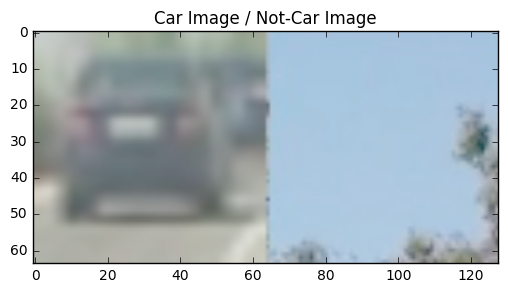

In [7]:
from sklearn.metrics import confusion_matrix
# Generate more data image using Gamma value(Darker or Brighter or Both)
gamma = [0.5,1,2]
# Read in cars and notcars from large dataset
cars = glob.glob('./dataset/vehicles/*/*.png')
notcars = glob.glob('./dataset/non-vehicles/*/*.png')

car_images = load_data_image(cars,gamma)
notcar_images = load_data_image(notcars,gamma)
print('Original Number of Car Images : ', len(cars))
print('Original Number of Not-Car Images : ', len(notcars))
#Sample Images
plt.title('Car Image / Not-Car Image')
plt.imshow(np.hstack((car_images[0],notcar_images[0])))
print('New Number of Car Images : ', len(car_images))
print('New Number of Not-Car Images : ', len(notcar_images))

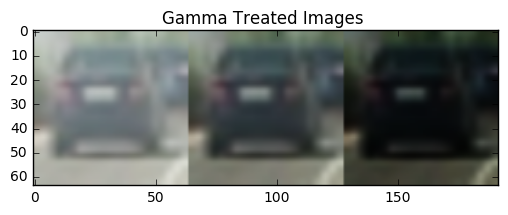

In [8]:
# Sample Images-Gamma Treated. 
# Later, When splitting data into training/Test dataset, all images need to be shuffled to be random sample. 
# which is the basic assumption for all statistical analysis
plt.title('Gamma Treated Images ')
plt.imshow(np.hstack((car_images[0],car_images[1],car_images[2])))

In [17]:
#Parameters for Test Constant
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, GRAY, YUL
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#feature extraction - To find best Color Space YUL is best after several trials
#New color space YUL is created with YU from YUV and L from HLS which has best record during 1 channel accuracy test
"""
color_space_set = ['YUL','YCrCb','RGB', 'HSV', 'HLS', 'GRAY'] #LUV, YUV is excluded due to error on V channel
accuracy = []
bcolor = None
bmodel = None
X_scaler = None
bacc = 0
for color_space in color_space_set:
    print('Color Space = ',color_space)
    car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    svc,acc,X_scaler = modeling(car_features,notcar_features,model='SVM')
    if bacc < acc :
        bcolor = color_space
        bmodel = svc
        bacc = acc
print ('Best Color Space = ', bcolor, ' with accuracy = ',bacc )
"""    

In [18]:
model = 'rbf'
parameters ={'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}

car_features = extract_features(car_images, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_images, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
svc,acc,X_scaler = modeling(car_features,notcar_features,model,parameters)

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7824
5807.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9992


In [19]:
# Originally, I used confusion Matrix to find Type 1 error and Type 2 error. 
# I think the decison about what object it is should be decided under conservative. 
# Detect Not-Car as Car is more hamful than detect car as not-car. Because other sensors can detect car correctly.
# But If Not-Car is detected as Car, It makes trouble to drive car right way due to wrong drive by wrong information
# print(confusion_matrix(y_test,svc.predict(X_test)))

# Store Best model in pickle file
f = open("svc_pickle_rbf_YCrCb.p", "wb" )

params ={"svc":svc, "scaler":X_scaler, "orient":orient, "pix_per_cell":pix_per_cell, "cell_per_block":cell_per_block, 
         "spatial_size":spatial_size, "hist_bins":hist_bins, 'spatial':spatial_feat, 'hist':hist_feat, 'hog':hog_feat,
         'color_space' : color_space}
pickle.dump(params, f)
f.close()